In [64]:
# Importing the libraries

import os
import gdal
import matplotlib.pyplot as plt
import numpy as np

# set the paths to the input tiff file and the shapefile
## Year
y = 19

tiff_paths = [
    fr'C:\Users\mirmazloumi\Nextcloud\01_data\external_data\Wapor\Phenology\20{y}\L2_KEN_PHE_{y}s1.tif',
    fr'C:\Users\mirmazloumi\Nextcloud\01_data\external_data\Wapor\Phenology\20{y}\L2_KEN_PHE_{y}m1.tif',
    fr'C:\Users\mirmazloumi\Nextcloud\01_data\external_data\Wapor\Phenology\20{y}\L2_KEN_PHE_{y}e1.tif',
    fr'C:\Users\mirmazloumi\Nextcloud\01_data\external_data\Wapor\Phenology\20{y}\L2_KEN_PHE_{y}s2.tif',
    fr'C:\Users\mirmazloumi\Nextcloud\01_data\external_data\Wapor\Phenology\20{y}\L2_KEN_PHE_{y}m2.tif',
    fr'C:\Users\mirmazloumi\Nextcloud\01_data\external_data\Wapor\Phenology\20{y}\L2_KEN_PHE_{y}e2.tif'
]



shapefile_path = r'C:\Users\mirmazloumi\Nextcloud\01_data\Study_Area_vector\gadm41_KEN_shp\gadm41_KEN_0.shp'

# open the shapefile and get its spatial reference system
shapefile_ds = gdal.OpenEx(shapefile_path, gdal.OF_VECTOR)
shapefile_layer = shapefile_ds.GetLayer()
shapefile_proj = shapefile_layer.GetSpatialRef()

# set the options for gdal.Warp() function
options = gdal.WarpOptions(
    cutlineDSName=shapefile_path,
    cropToCutline=True,
    dstNodata=255, ## pixel values out of the clipped area
)

output_paths = []

for i, tiff_path in enumerate(tiff_paths):
    # set the output tiff file name and path
    output_path = f'output_{i+1}_20{y}.tif'
    output_paths.append(output_path)
    # open the input tiff file and get its spatial reference system
    tiff_ds = gdal.Open(tiff_path)
    tiff_proj = tiff_ds.GetProjection()
    
    # clip the input tiff file using the shapefile
    clipped_ds = gdal.Warp(output_path, tiff_ds, options=options)
    
    # read the pixel values from the clipped tiff file
    output_ds = gdal.Open(output_path)

    # close the datasets
    tiff_ds = None
    clipped_ds = None
    output_ds = None
    
# close the shapefile dataset
shapefile_ds = None

print(output_paths)

['output_1_2019.tif', 'output_2_2019.tif', 'output_3_2019.tif', 'output_4_2019.tif', 'output_5_2019.tif', 'output_6_2019.tif']


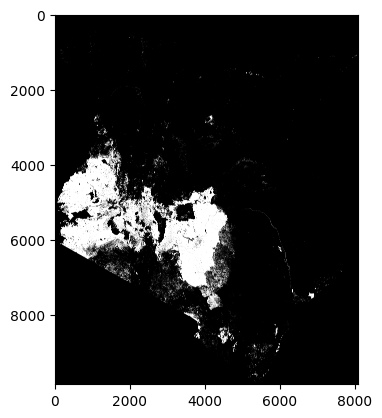

In [65]:
# Reading the corresponding LCC maps

LCC_path = fr'C:\Users\mirmazloumi\Nextcloud\01_data\external_data\Wapor\LCC\L2_KEN_LCC_{y}.tif'
LCC = gdal.Open(LCC_path)
output_path_busia = f'output_busia_lcc_20{y}.tif'



# set the options for gdal.Warp() function
options_2 = gdal.WarpOptions(
    cutlineDSName=shapefile_path,
    cropToCutline=True,
    dstNodata=256, ## pixel values out of the clipped area
)

# clip the input tiff file using the shapefile
clipped_lcc_busia=gdal.Warp(output_path_busia, LCC, options=options_2)

output_lcc_busia = gdal.Open(output_path_busia)
raster_array_busia = output_lcc_busia.ReadAsArray()

cropland_IDs = [41, 42, 43]



binary_array = np.zeros(raster_array_busia.shape, dtype=np.uint8)
for clip_value in cropland_IDs:
    binary_array[raster_array_busia == clip_value] = 1
    
    
# create a new GeoTIFF file for the binary mask
output_file = gdal.GetDriverByName('GTiff').Create(f'output_busia_lcc_20{y}_masked.tif', raster_array_busia.shape[1], 
                                                   raster_array_busia.shape[0], 1, gdal.GDT_Byte)

# set the spatial reference and geotransform of the output file to match the input file
output_file.SetProjection(output_lcc_busia.GetProjection())
output_file.SetGeoTransform(output_lcc_busia.GetGeoTransform())

# write the binary array to the output file
output_file.GetRasterBand(1).WriteArray(binary_array)

# close the output file
output_file = None

# read the binary array from the output file and display it
clipped_lcc = gdal.Open(f'output_busia_lcc_20{y}_masked.tif').ReadAsArray()
plt.imshow(clipped_lcc, cmap='gray')
plt.show()

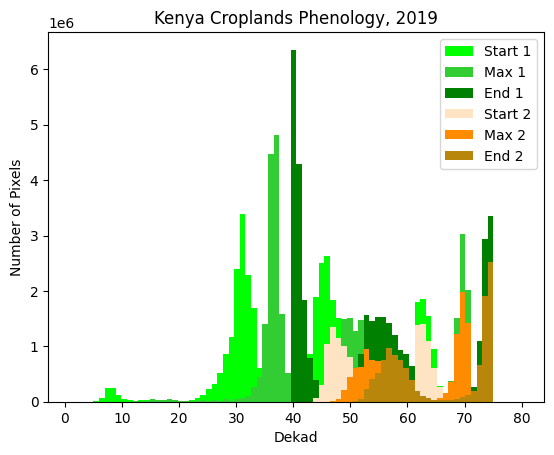

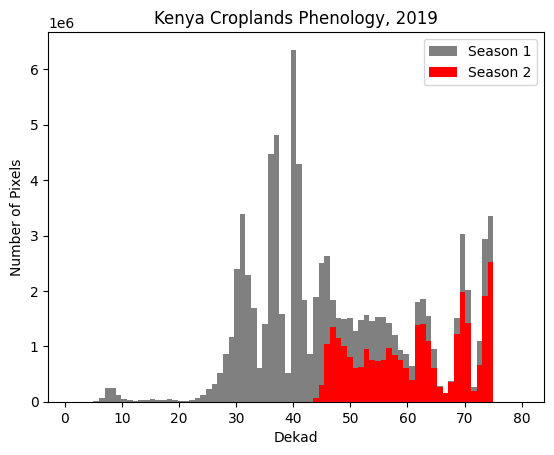

In [66]:
# Visualizing and saving the phenology plots

output_ds = []
for path in output_paths:
    output_ds.append(gdal.Open(path))

clipped_lcc = gdal.Open(f'output_busia_lcc_20{y}_masked.tif')

cols = output_ds[0].RasterXSize
rows = output_ds[0].RasterYSize
output = []
for i in range(len(output_ds)):
    output.append(np.zeros((rows, cols), dtype=np.uint8))

input_data = []
for ds in output_ds:
    input_data.append(ds.GetRasterBand(1).ReadAsArray())

mask_data = clipped_lcc.GetRasterBand(1).ReadAsArray()
mask = np.logical_and(mask_data, 1)

for i in range(len(output_ds)):
    output_data = output[i].copy()  # Make a copy of output array to avoid changing original array
    output_data[mask] = input_data[i][mask]
    driver = gdal.GetDriverByName("GTiff")
    output_file = driver.Create(f"{os.path.splitext(output_paths[i])[0]}_20{y}_cropland.tif", cols, rows, 1, gdal.GDT_Byte)
    output_file.SetProjection(output_lcc_busia.GetProjection())
    output_file.SetGeoTransform(output_lcc_busia.GetGeoTransform())
    output_file.GetRasterBand(1).WriteArray(output_data)


s_lcc_masked = []
for path in output_paths:
    try:
        ds = gdal.Open(f'{path}')
        s_lcc_masked.append(ds.GetRasterBand(1).ReadAsArray())
    except Exception as e:
        print(f"Error opening file {path}_cropland.tif: {e}")
    

    
start_bin = 1    
n_bins = 80

plt.hist(s_lcc_masked[0].ravel(), bins=n_bins, range=(start_bin, n_bins), color='lime', label = 'Start 1')
plt.hist(s_lcc_masked[1].ravel(), bins=n_bins, range=(start_bin, n_bins), color='limegreen', label = 'Max 1')
plt.hist(s_lcc_masked[2].ravel(), bins=n_bins, range=(start_bin, n_bins), color='green', label = 'End 1')

plt.hist(s_lcc_masked[3].ravel(), bins=n_bins, range=(start_bin, n_bins), color='bisque', label = 'Start 2')
plt.hist(s_lcc_masked[4].ravel(), bins=n_bins, range=(start_bin, n_bins), color='darkorange', label = 'Max 2')
plt.hist(s_lcc_masked[5].ravel(), bins=n_bins, range=(start_bin, n_bins), color='darkgoldenrod', label = 'End 2')

plt.title(f'Kenya Croplands Phenology, 20{y}')
plt.legend()
plt.xlabel('Dekad')
plt.ylabel('Number of Pixels')
plt.savefig(fr'H:\ADM-Kenya\Phenology_Wapor\Kenya Croplands Phenology, 20{y}_colorful.tif', dpi = 100)
plt.show()

plt.hist(s_lcc_masked[0].ravel(), bins=n_bins, range=(start_bin, n_bins), color='gray', label = 'Season 1')
plt.hist(s_lcc_masked[1].ravel(), bins=n_bins, range=(start_bin, n_bins), color='gray')
plt.hist(s_lcc_masked[2].ravel(), bins=n_bins, range=(start_bin, n_bins), color='gray')

plt.hist(s_lcc_masked[3].ravel(), bins=n_bins, range=(start_bin, n_bins), color='red', label = 'Season 2')
plt.hist(s_lcc_masked[4].ravel(), bins=n_bins, range=(start_bin, n_bins), color='red')
plt.hist(s_lcc_masked[5].ravel(), bins=n_bins, range=(start_bin, n_bins), color='red')

plt.title(f'Kenya Croplands Phenology, 20{y}')
plt.legend()
plt.xlabel('Dekad')
plt.ylabel('Number of Pixels')

plt.savefig(fr'H:\ADM-Kenya\Phenology_Wapor\Kenya Croplands Phenology, 20{y}.tif', dpi = 100)
plt.show()

In [20]:
# Calculating the day of year from dekadal values

import datetime

y = 18
year = int(f"20{y}")
dekad_phenology = 35
dekad = dekad_phenology - 36

# Get the date corresponding to the start of the dekad
start_date = datetime.date(year, 1, 1) + datetime.timedelta((dekad - 1) * 10)

# Calculate the day of year (1-365 or 366 for leap years)
doy = start_date.timetuple().tm_yday

# Convert the day of year to a date object
date_obj = datetime.datetime(year, 1, 1) + datetime.timedelta(doy - 1)

# Extract the day and month from the date object
day = date_obj.day
month = date_obj.month
month_name = start_date.strftime('%B')


print(f"Year: {year}")
print(f"Dekad: {dekad}")
print(f"Day of Year: {doy}")
print(f"Day: {day}")
print(f"Month: {month}")
print(f"Month: {month_name}")

def dekad_to_doy(year, dekad):
    # Get the date corresponding to the start of the dekad
    start_date = datetime.date(year, 1, 1) + datetime.timedelta((dekad - 1) * 10)

    # Calculate the day of year (1-365 or 366 for leap years)
    doy = start_date.timetuple().tm_yday
    
    return doy

doy = dekad_to_doy(year, dekad)

Year: 2018
Dekad: -1
Day of Year: 346
Day: 12
Month: 12
Month: December
